# RAI Controller Monitoring

Visualize historical and extrapolated controller performance on mainnet

In [1]:
import os
import time
import math
from decimal import Decimal
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
from sklearn.metrics import mean_squared_error
from web3 import Web3, HTTPProvider


# import abis
from abis.abis import GEB_RRFM_SETTER_ABI, GEB_RRFM_CALCULATOR_ABI

# simulation of Rai system
from rai import Rai, WAD, RAY

size = 15
PLT_PARAMS = {'legend.fontsize': 'large',
          'figure.figsize': (20,12),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}

SMALL_SIZE = (10.5, 6)
plt.rcParams.update(PLT_PARAMS)

System and RPC Parameters

In [2]:
# Need an archive node
ETH_RPC_URL=os.environ['ETH_RPC_URL']
w3 = Web3(Web3.HTTPProvider(ETH_RPC_URL, request_kwargs={"timeout": 10}))

In [3]:
# Contract addresses

# UpdateRedemptionRate events come from the rate setter
GEB_RRFM_SETTER="0x7Acfc14dBF2decD1c9213Db32AE7784626daEb48"

# Will retrive sg, ag, pscl from rate calc
GEB_RRFM_CALCULATOR="0xddA334de7A9C57A641616492175ca203Ba8Cf981"

# new scaled controller
NEW_GEB_RRFM_CALCULATOR="0x5CC4878eA3E6323FdA34b3D28551E1543DEe54C6"

# Contract Instances
rate_setter = w3.eth.contract(address=GEB_RRFM_SETTER, abi=GEB_RRFM_SETTER_ABI)
RATE_CALC = w3.eth.contract(address=GEB_RRFM_CALCULATOR, abi=GEB_RRFM_CALCULATOR_ABI)
NEW_RATE_CALC = w3.eth.contract(address=NEW_GEB_RRFM_CALCULATOR, abi=GEB_RRFM_CALCULATOR_ABI)

In [4]:
def gather_data(first_block, last_block):
    ''' Collect data from events and function calls '''
    new_calc_deploy_block = 15046690
    
    update_rr_filter = {'fromBlock': first_block, 'toBlock': last_block, 'address': GEB_RRFM_SETTER,
                         'topics': ['0x16abce12916e67b821a9cdabe7103d806d6f4280a69d5830925b3e34c83f52a8']}
    logs = w3.eth.get_logs(update_rr_filter)

    results = []
    for log in logs:
        event = []
        p_log = rate_setter.events.UpdateRedemptionRate().processLog(log)

        event.append(p_log['args']['marketPrice'])
        event.append(p_log['args']['redemptionPrice'])
        event.append(p_log['args']['redemptionRate'])
        event.append(p_log['transactionHash'].hex())
        event.append(p_log['address'])
        event.append(p_log['blockNumber'])
        ts = w3.eth.get_block(p_log['blockNumber'])['timestamp']

        # Rate calc variables
        if p_log['blockNumber'] < new_calc_deploy_block: 
            current_rate_calc = RATE_CALC
        else:
            current_rate_calc = NEW_RATE_CALC

        prop_term = current_rate_calc.caller(block_identifier=p_log['blockNumber']).getLastProportionalTerm()
        integral_term = current_rate_calc.caller(block_identifier=p_log['blockNumber']).getLastIntegralTerm()
        sg = current_rate_calc.caller(block_identifier=p_log['blockNumber']).sg()
        ag = current_rate_calc.caller(block_identifier=p_log['blockNumber']).ag()
        pscl = current_rate_calc.caller(block_identifier=p_log['blockNumber']).pscl()

        event.append(ts)
        event.append(prop_term)
        event.append(integral_term)
        event.append(sg)
        event.append(ag)
        event.append(pscl)
        results.append(event)
        
    return results

 Load previously fetched data

In [5]:
df_orig = pd.read_csv('output/raw_data.csv.gz')
# resume at first block after last block processed
first_block = int(df_orig['blockNumber'].iloc[-1]) + 1
print(f"{first_block=}")

# These are used only if we have recreate the entire dataset
#calc_deploy_block = 14226200
#new_calc_deploy_block = 15046690

first_block=15161726


Fetch new events

In [6]:
results = gather_data(first_block, 'latest')

Create dataframe of new events and combine with old data. Save updated raw data.

In [7]:
df_new = pd.DataFrame(results, columns=['marketPrice', 'redemptionPrice', 'redemptionRate', 'transactionHash',\
                                    'address', 'blockNumber', 'ts', 'prop_term', 'integral_term', 'sg', 'ag', 'pscl'])
print(f"Processing {len(df_new)} new events")

Processing 0 new events


In [8]:
if len(df_new) > 0:
    df = pd.concat((df_orig, df_new))
    df.to_csv('output/raw_data.csv.gz', index=False)
else:
    df = df_orig

Data Transformations

In [9]:
df['prop_term'] = df['prop_term'].astype(float)
df['integral_term'] = df['integral_term'].astype(float)

In [10]:
df['timestamp'] = pd.to_datetime(df['ts'], unit='s')

In [11]:
df = df.set_index('timestamp')

In [12]:
# these are delta rates, not per-second rates
df['p_rate_delta'] = (df['prop_term'] * df['sg'])/1e18
df['i_rate_delta'] = (df['integral_term'] * df['ag'])/1e18

In [13]:
# create total per-second rate
df['total_rate'] = (1e27 + df['p_rate_delta'] + df['i_rate_delta'])

# convert these to per-second rates
df['p_rate'] = 1e27 + df['p_rate_delta']
df['i_rate'] = 1e27 + df['i_rate_delta']

In [14]:
# calculate annual rates
df['redemptionRate_apy'] = (df['redemptionRate'].apply(Decimal).apply(lambda x: (x/Decimal(1e27))**(86400*365)) - 1) * 100
df['total_rate_apy'] = (df['total_rate'].apply(Decimal).apply(lambda x: (x/Decimal(1e27))**(86400*365)) - 1) * 100
df['p_rate_apy'] = (df['p_rate'].apply(lambda x: Decimal(int(x))).apply(lambda x: (x/Decimal(1e27))**(86400*365)) - 1) * 100
df['i_rate_apy'] = (df['i_rate'].apply(Decimal).apply(lambda x: (x/Decimal(1e27))**(86400*365)) - 1) * 100

In [15]:
df['apy_diff'] = df['redemptionRate_apy'] - df['total_rate_apy']

Convert for plotting

In [16]:
df['marketPrice'] = df['marketPrice'].apply(lambda x: int(x)/1e27)
df['redemptionPrice'] = df['redemptionPrice'].apply(lambda x: int(x)/1e27)

In [17]:
df['total_rate_apy'] = df['total_rate_apy'].apply(float)
df['p_rate_apy'] = df['p_rate_apy'].apply(float)
df['i_rate_apy'] = df['i_rate_apy'].apply(float)

df['p_rate_delta'] = df['p_rate_delta'].apply(float)
df['i_rate_delta'] = df['i_rate_delta'].apply(float)

Save updated final tranformed data

In [18]:
df.to_csv('output/final_data.csv.gz')

In [19]:
plt.ioff()

# Historical Plot
Plot total, p and i rates

In [20]:
def plot(df, title, output_png, timestamp, size=None, linewidth=1.5):

    fig, ax = plt.subplots(2, 1, sharex=True)
    if size:
        fig.set_size_inches(size[0], size[1])

    ax[0].plot(df[['marketPrice']], label='market', color='#d62728', linewidth=linewidth)
    ax[0].plot(df[['redemptionPrice']], label='redemption', color='black', alpha=0.5, linewidth=linewidth)
    ax[0].legend()
    ax[0].grid()


    '''
    df[['total_rate_apy', 'p_rate_apy', 'i_rate_apy']].plot(ax=ax[1],
                                                            color=['black', '#1f77b4', '#ff7f0e'],
                                                            linewidth=linewidth)
    ax[1].grid()
    '''
    
    
    '''
    ax[1].stackplot(df.index, df['p_rate_delta'], baseline='zero', alpha=0.7,
                   labels=['p_rate per-sec(delta)'])
    
    ax[1].stackplot(df.index, df['i_rate_delta'], baseline='zero', alpha=0.7,
                   labels=['i_rate per-sec(delta)'])   
    '''
    
    ax[1].stackplot(df.index, df['p_rate_apy'], baseline='zero', alpha=0.7,
                   labels=['p_rate apy'])
    
    ax[1].stackplot(df.index, df['i_rate_apy'], baseline='zero', alpha=0.7,
                   labels=['i_rate apy'])   
    
    
    ax[1].legend(loc='lower left')
    ax[1].grid()
    
    plt.suptitle(title, size=18)
    
    ax[0].axvline(timestamp, color="black", linestyle="dashed", alpha=0.5)
    ax[1].axvline(timestamp, color="black", linestyle="dashed", alpha=0.5)
    #ax[2].axvline(timestamp, color="black", linestyle="dashed", alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(output_png, facecolor='white', transparent=False)
    
    plt.show()

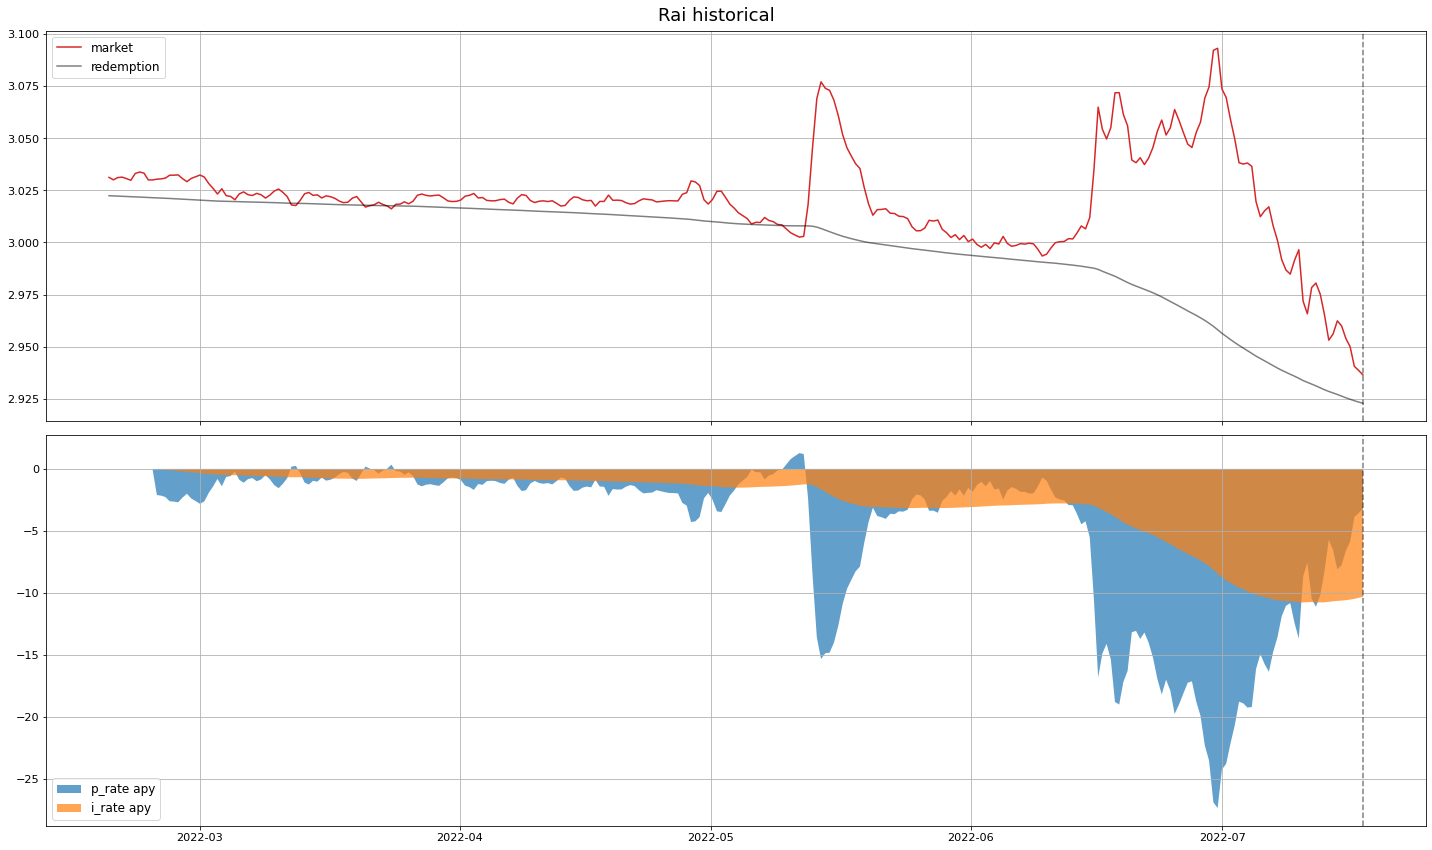

In [21]:
plot(df, "Rai historical", 'output/controller_monitoring.png',
     timestamp=pd.to_datetime(int(df['ts'].iloc[-1]), unit='s'))

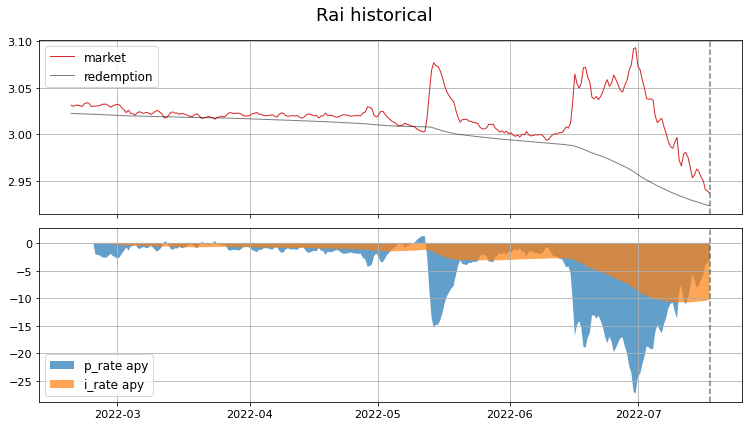

In [22]:
plot(df, "Rai historical", 'output/controller_monitoring_small.png',
     timestamp=pd.to_datetime(int(df['ts'].iloc[-1]), unit='s'), size=SMALL_SIZE, linewidth=1)

# Extrapolation

Parameters

In [23]:
# Number of market price TWAP updates to peform
N_STEPS = 200

# Interval between market price TWAP updates
UPDATE_INTERVAL = 12 * 3600

Retrieve most recent state

In [24]:
df.tail(1)

,marketPrice,redemptionPrice,redemptionRate,transactionHash,address,blockNumber,ts,prop_term,integral_term,sg,...,p_rate_delta,i_rate_delta,total_rate,p_rate,i_rate,redemptionRate_apy,total_rate_apy,p_rate_apy,i_rate_apy,apy_diff
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-07-17 18:26:11,2.936438,2.922839,999999995513144543070774451,0x0421ad83352deec2b8781bacc08ea3eda28f37a0415a...,0x7Acfc14dBF2decD1c9213Db32AE7784626daEb48,15161725,1658082371,-4.652840e+24,-4.861929e+31,222002205862,...,-1.032941e+18,-3.453915e+18,1.000000e+27,1.000000e+27,1.000000e+27,-13.19426320749276899511828155,-13.194263,-3.204997,-10.320022,-8.362471832895594061E-8


In [25]:
kp = df['sg'].iloc[-1] # WAD
ki = df['ag'].iloc[-1] # WAD
alpha = df['pscl'].iloc[-1]
prop_term = df['prop_term'].iloc[-1] # RAY
integral_term = df['integral_term'].iloc[-1]# RAY
last_ts = int(df['ts'].iloc[-1])
last_timestamp = pd.to_datetime(last_ts, unit='s')

last_market_price = df['marketPrice'].iloc[-1]
last_redemption_price = df['redemptionPrice'].iloc[-1]
last_redemption_rate = df['redemptionRate'].iloc[-1] # RAY, per-sec

In [26]:
print(f"{last_timestamp=}")
print(f"{kp=}")
print(f"{ki=}")
print(f"{alpha=}")
print(f"{prop_term=}")
print(f"{integral_term=}")
print(f"{last_redemption_rate=}")

last_timestamp=Timestamp('2022-07-17 18:26:11')
kp=222002205862
ki=71040
alpha='999999711200000000000000000'
prop_term=-4.6528402507282496e+24
integral_term=-4.861929416869444e+31
last_redemption_rate='999999995513144543070774451'


Helper functions for extrapolation

In [27]:
def post_process(results):
    ''' Prepare sim results for merging with old data and plotting '''
    df = pd.DataFrame(results, columns=['ts', 'total_rate', 'p_rate_delta', 'i_rate_delta', 'redemptionPrice', 'marketPrice'])
    df['timestamp'] = pd.to_datetime(df['ts'], unit='s')
    df = df.set_index('timestamp')
    
    # create total per-second rate
    #df['total_rate'] = (1e27 + df['p_rate_delta'] + df['i_rate_delta'])

    # convert these to per-second rates
    df['p_rate'] = 1e27 + df['p_rate_delta']
    df['i_rate'] = 1e27 + df['i_rate_delta']
    
    df['total_rate_apy'] = (df['total_rate'].apply(Decimal).apply(lambda x: (x/Decimal(1e27))**(86400*365)) - 1) * 100
    df['p_rate_apy'] = (df['p_rate'].apply(lambda x: Decimal(int(x))).apply(lambda x: (x/Decimal(1e27))**(86400*365)) - 1) * 100
    df['i_rate_apy'] = (df['i_rate'].apply(Decimal).apply(lambda x: (x/Decimal(1e27))**(86400*365)) - 1) * 100

    df['total_rate_apy'] = df['total_rate_apy'].apply(float)
    df['p_rate_apy'] = df['p_rate_apy'].apply(float)
    df['i_rate_apy'] = df['i_rate_apy'].apply(float)

    df['p_rate_delta'] = df['p_rate_delta'].apply(float)
    df['i_rate_delta'] = df['i_rate_delta'].apply(float) 
    
    return df

def merge(df, df_new):
    ''' Merge post-processed sim results with old data '''
    merged = pd.concat([df, df_new], axis=0, ignore_index=True) 
    
    merged['timestamp'] = pd.to_datetime(merged['ts'], unit='s')
    merged = merged.set_index('timestamp')
    
    return merged   

Function to plot simulation output

## Extrapolation #1 : Constant Market Prices

Hold market price constant.

In [28]:
# Constant Market Prices
results_e = []
market_prices = [last_market_price for _ in range(N_STEPS)]
timestamps = [last_ts + i*UPDATE_INTERVAL for i in range(1, N_STEPS + 1)]

rai = Rai(last_redemption_price, last_redemption_rate, last_ts, kp, ki, alpha, prop_term, integral_term)
for i, mp in enumerate(market_prices):
    ts, total_rate, p_rate, i_rate, rp, mp = rai.process(mp, int(timestamps[i]))
    results_e.append((ts, total_rate, p_rate, i_rate, rp, mp))

In [29]:
df_e = post_process(results_e)
merged_e = merge(df, df_e)

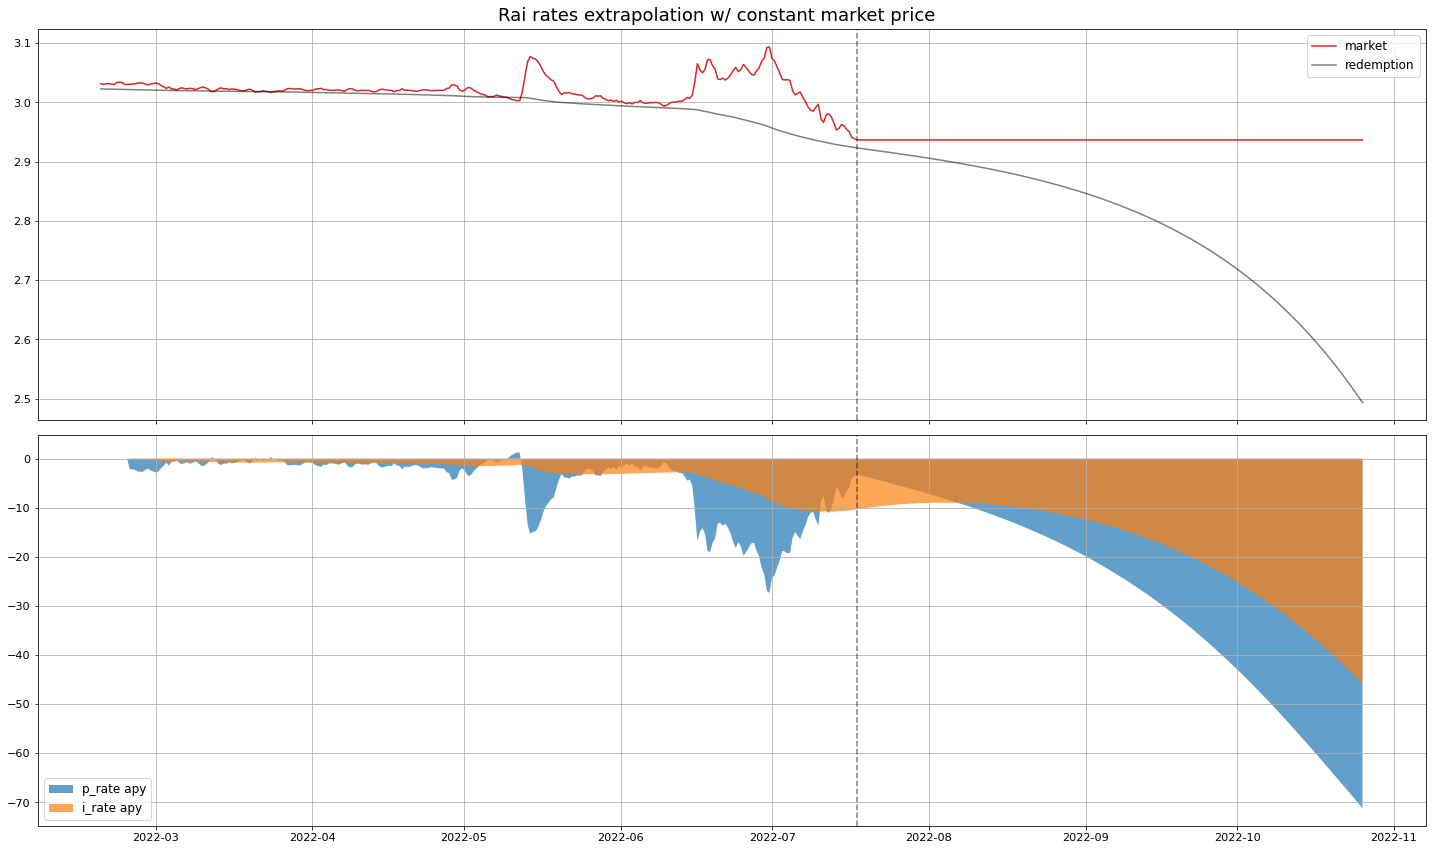

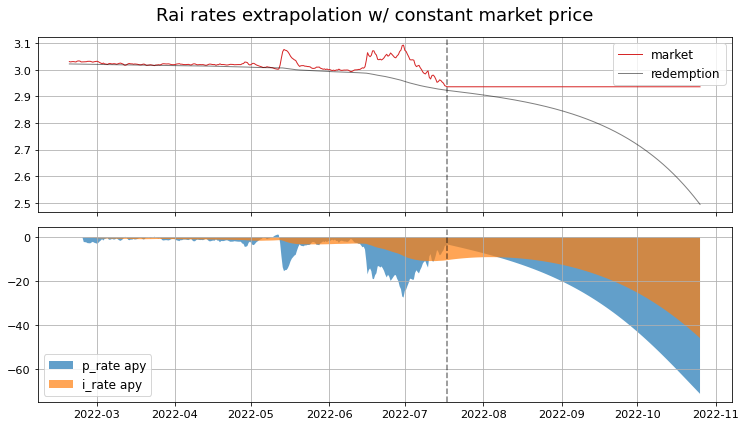

In [30]:
plot(merged_e, "Rai rates extrapolation w/ constant market price",
     'output/extrapolation_constant_market.png', last_timestamp)
plot(merged_e, "Rai rates extrapolation w/ constant market price",
     'output/extrapolation_constant_market_small.png', last_timestamp, size=SMALL_SIZE, linewidth=1)

## Extrapolation #2 : Converged Market Prices

Market price equals redemption price

In [31]:
# Converged Market Prices
rai = Rai(last_redemption_price, last_redemption_rate, last_ts, kp, ki, alpha, prop_term, integral_term)
results_conv = []
for ts in timestamps:
    ts, total_rate, p_rate, i_rate, rp, mp = rai.process(rai.redemption_price, int(ts))
    results_conv.append((ts, total_rate, p_rate, i_rate, rp, mp))

In [32]:
df_conv = post_process(results_conv)
merged_conv = merge(df, df_conv)

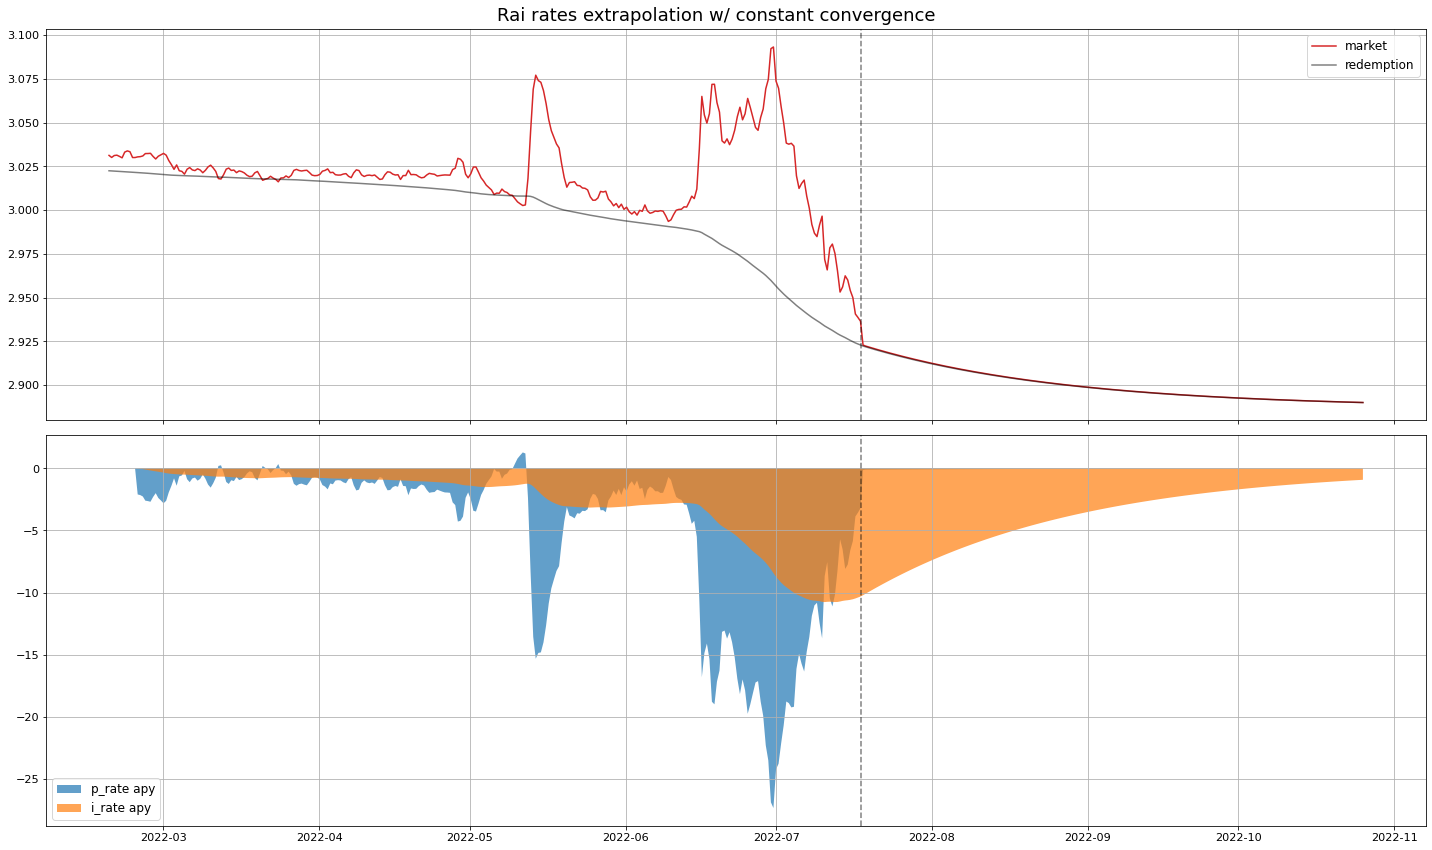

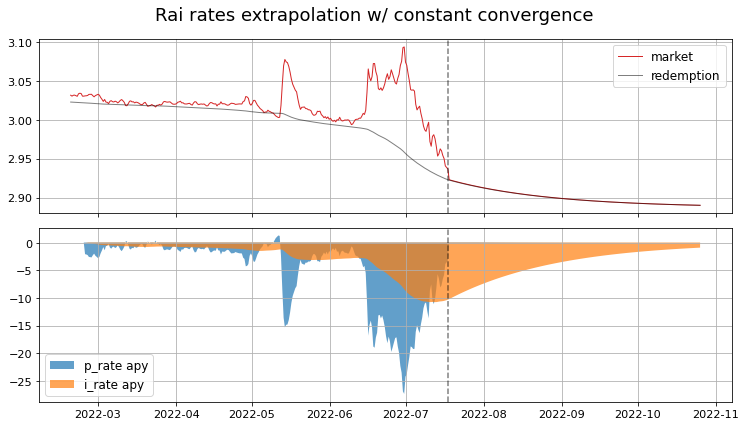

In [33]:
plot(merged_conv, "Rai rates extrapolation w/ constant convergence",
     'output/extrapolation_constant_convergence.png', last_timestamp)
plot(merged_conv, "Rai rates extrapolation w/ constant convergence",
     'output/extrapolation_constant_convergence_small.png', last_timestamp, size=SMALL_SIZE, linewidth=1)

## Extrapolation #3 : Zero-rate Market Prices

Market price creates zero total rate.

In [34]:
# Zero rate market prices
rai = Rai(last_redemption_price, last_redemption_rate, last_ts, kp, ki, alpha, prop_term, integral_term)
results_zero = []
for ts in timestamps:
    # current iRate(delta)
    ki_rate = rai.ki/WAD * rai.integral_term
    # current pRate(Delta)
    
    kp_rate = rai.kp/WAD * rai.prop_term

    nec_prop_term = -ki_rate/rai.kp * WAD
    
    #print(rai.prop_term, nec_prop_term)
    #kp_rate = kp * error
    needed_error = -ki_rate/rai.kp/WAD
    #print(ki_rate, needed_error)
    input_mp = float(rai.redemption_price) - (nec_prop_term/1e27 * float(rai.redemption_price))
    #print(input_mp)
    ts, total_rate, p_rate, i_rate, rp, mp = rai.process(input_mp, int(ts))
    results_zero.append((ts, total_rate, p_rate, i_rate, rp, mp))

In [35]:
df_zero= post_process(results_zero)
merged_zero = merge(df, df_zero)

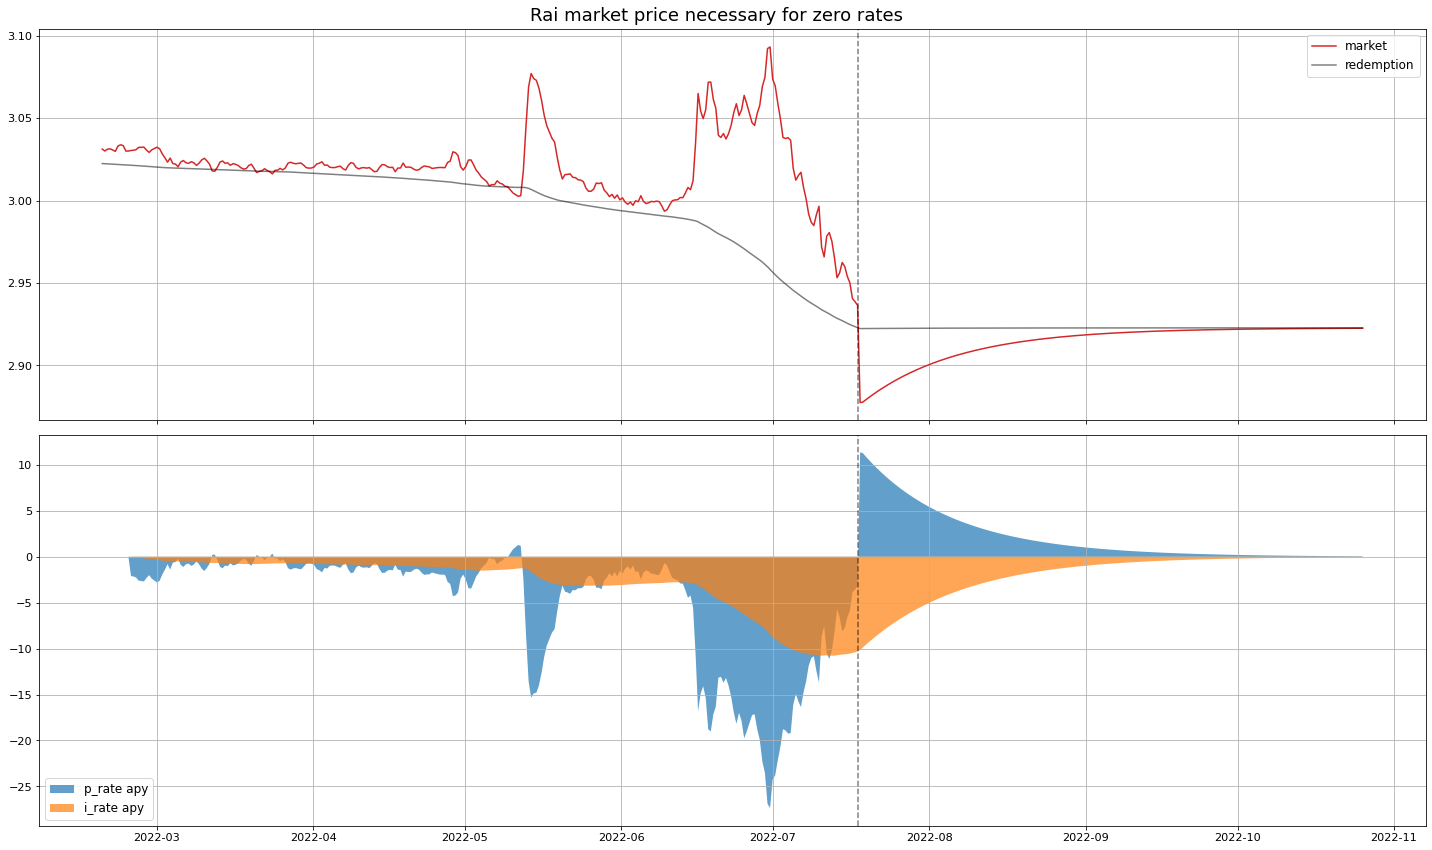

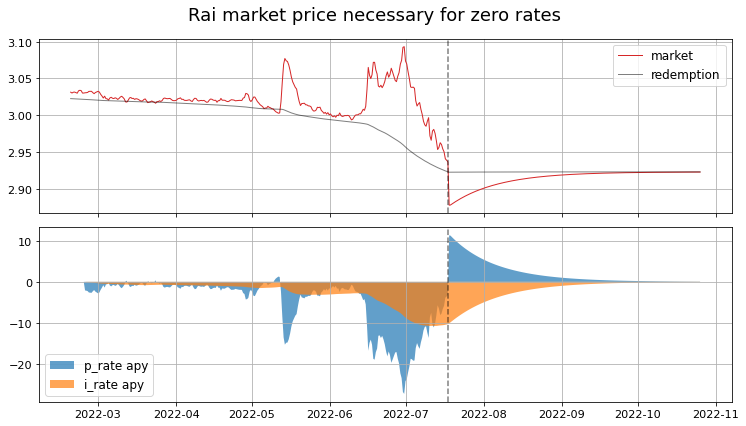

In [36]:
plot(merged_zero, "Rai market price necessary for zero rates",
     'output/extrapolation_zero_rates.png', last_timestamp)
plot(merged_zero, "Rai market price necessary for zero rates",
     'output/extrapolation_zero_rates_small.png', last_timestamp, size=SMALL_SIZE, linewidth=1)

## Extrapolation #4 : Market steps

Market price steps to a price and stays there

Function for just plotting market and redemption

In [37]:
def plot_simple(df, title=None, ax=None, linewidth=1.5):
    ax.plot(df[['marketPrice']], label='market', color='#d62728', linewidth=linewidth)
    ax.plot(df[['redemptionPrice']], label='redemption', color='black', alpha=0.5, linewidth=linewidth)
    ax.legend()
    if title:
        ax.set_title(title)
    ax.grid()
    
def plot_steps(merged_steps, price_steps, output_png, timestamp, tight=False, size=None, linewidth=1.5):
    x = math.ceil(math.sqrt(len(price_steps)))
    y = math.floor(math.sqrt(len(price_steps)))
    
    fig, ax = plt.subplots(x, y, sharex=True)
      
    if size:
        fig.set_size_inches(size[0], size[1])

    sup_title = None
    for i, step in enumerate(price_steps):
        this_ax = ax.ravel()[i] if isinstance(ax, np.ndarray) else ax
        if len(price_steps) == 1:
            ax_title = None
            sup_title = f"Rai rates extrapolation w/ step to {step}"
        else:
            ax_title = f"Rai rates extrapolation w/ step to {step}"
        plot_simple(merged_steps[step], ax_title, ax=this_ax, linewidth=linewidth)
        
        this_ax.axvline(timestamp, color="black", linestyle="dashed", alpha=0.5)
          
    if sup_title:    
        plt.suptitle(sup_title, size=18)    
        plt.subplots_adjust(top=0.8)
    if tight:
        plt.tight_layout()
        
    plt.savefig(output_png, facecolor='white', transparent=False)
    plt.show()
    
def plot_one_step(merged_steps, price_steps, title, output_png, timestamp, tight=False, size=None, linewidth=1.5):
    
    if len(price_steps) > 1:
        raise ValueError('use plot_steps() for multiple price steps')
        
    df = merged_steps[price_steps[0]]
    fig, ax = plt.subplots(2, 1, sharex=True)
      
    if size:
        fig.set_size_inches(size[0], size[1])
                
    ax[0].plot(df[['marketPrice']], label='market', color='#d62728', linewidth=linewidth)
    ax[0].plot(df[['redemptionPrice']], label='redemption', color='black', alpha=0.5, linewidth=linewidth)
    ax[0].legend()

    ax[0].grid()
    ax[0].axvline(timestamp, color="black", linestyle="dashed", alpha=0.5)
                
    ax[1].stackplot(df.index, df['p_rate_apy'], baseline='zero', alpha=0.7,
                   labels=['p_rate apy'])
    
    ax[1].stackplot(df.index, df['i_rate_apy'], baseline='zero', alpha=0.7,
                   labels=['i_rate apy'])
      
    ax[1].legend(loc='lower left')
    ax[1].grid()
   
    plt.suptitle(title, size=18)    
    if tight:
        plt.tight_layout()
        
    plt.savefig(output_png, facecolor='white', transparent=False)
    plt.show()
    

In [38]:
def post_process_steps(results_step, price_steps):
    df_steps = {}
    for step in price_steps:
        df_steps[step] = post_process(results_steps[step])
    
    merged_steps = {}
    for step, df_step in df_steps.items():
        merged_steps[step] = merge(df, df_step) 
        
    return merged_steps

#### Extrapolation #4a : Find market step that produces the best final convergence

In [39]:
# Step Market Prices

# Number of different price steps to simulate
# This is different than N_STEPS(time) defined above
N_PRICE_STEPS = 100

MIN_PRICE_STEP = last_redemption_price -0.02
MAX_PRICE_STEP = last_redemption_price - 0.01

price_steps = np.round(np.linspace(MIN_PRICE_STEP, MAX_PRICE_STEP, N_PRICE_STEPS), 5)
results_steps = {}
timestamps = [last_ts + i*UPDATE_INTERVAL for i in range(1, N_STEPS + 1)]
errors = []
for step in price_steps:
    market_prices = [step for _ in range(N_STEPS)]
    results_steps[step] = []
    
    rai = Rai(last_redemption_price, last_redemption_rate, last_ts, kp, ki, alpha, prop_term, integral_term)
    for i, mp in enumerate(market_prices):
        ts, total_rate, p_rate, i_rate, rp, mp = rai.process(mp, int(timestamps[i]))
        results_steps[step].append((ts, total_rate, p_rate, i_rate, rp, mp)) 
    x = np.array(results_steps[step])
    errors.append((step, abs(float(x[-1, -2]) - x[-1, -1])))    

In [40]:
min_error_step = min(errors, key=lambda x: x[1])
print(f"The final absolute error(market-redemption) after {N_STEPS=} is achieved by a market step to {min_error_step=}")

The final absolute error(market-redemption) after N_STEPS=200 is achieved by a market step to min_error_step=(2.90637, 0.0007264753091074105)


Plot min error step

In [41]:
price_steps = [min_error_step[0]]
results_steps = {}
timestamps = [last_ts + i*UPDATE_INTERVAL for i in range(1, N_STEPS + 1)]
errors = []
for step in price_steps:
    market_prices = [step for _ in range(N_STEPS)]
    results_steps[step] = []
    
    rai = Rai(last_redemption_price, last_redemption_rate, last_ts, kp, ki, alpha, prop_term, integral_term)
    for i, mp in enumerate(market_prices):
        ts, total_rate, p_rate, i_rate, rp, mp = rai.process(mp, int(timestamps[i]))
        results_steps[step].append((ts, total_rate, p_rate, i_rate, rp, mp)) 

In [42]:
merged_steps = post_process_steps(results_steps, price_steps)

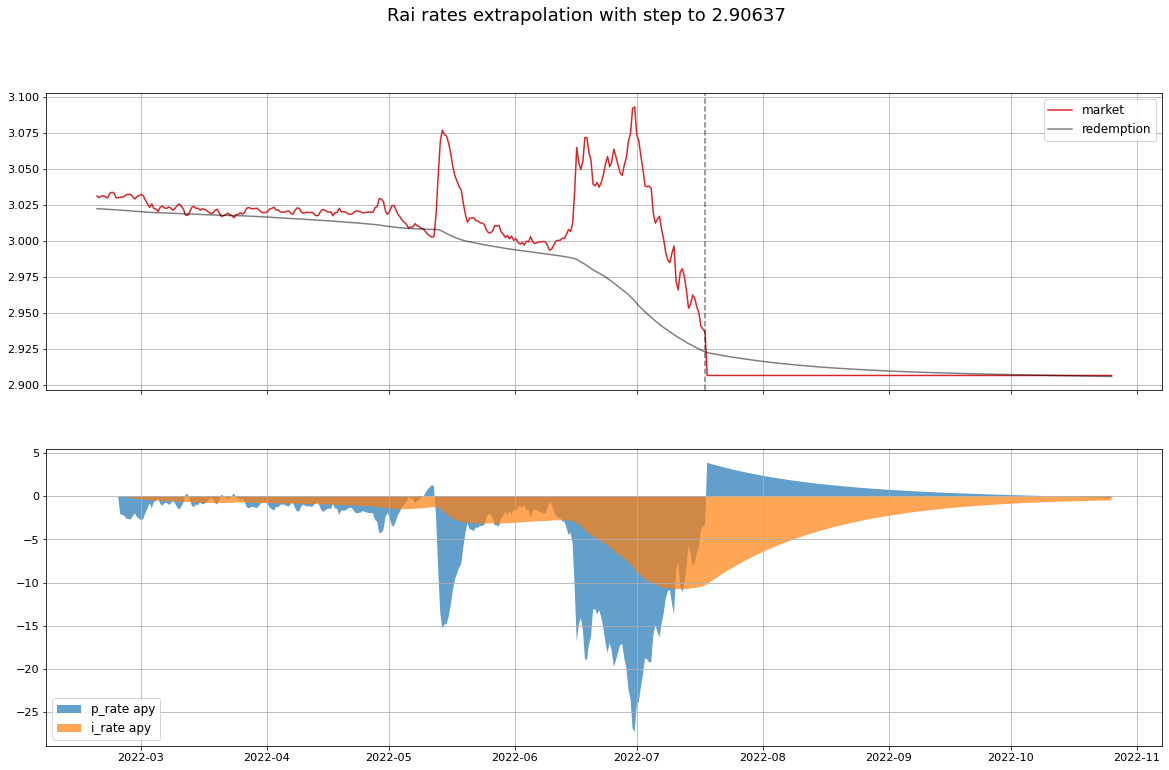

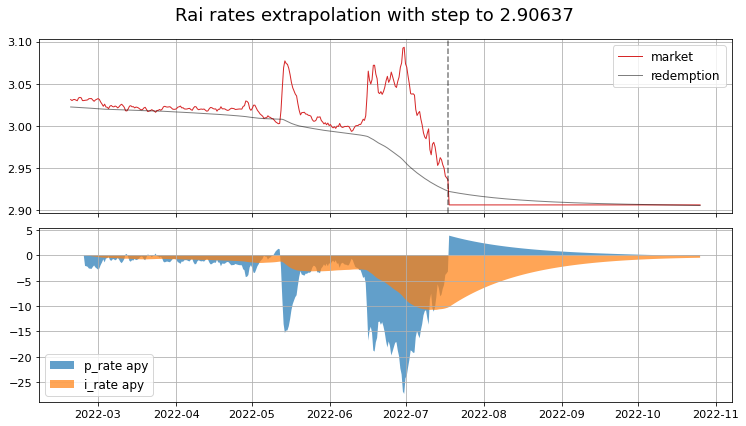

In [43]:
plot_one_step(merged_steps, price_steps, f'Rai rates extrapolation with step to {price_steps[0]}', f'output/controller_extrapolation_{len(price_steps)}_steps.png',
           last_timestamp)
plot_one_step(merged_steps, price_steps, f'Rai rates extrapolation with step to {price_steps[0]}', f'output/controller_extrapolation_{len(price_steps)}_steps_small.png',
           last_timestamp, size=SMALL_SIZE, linewidth=1, tight=True)

#### Extrapolation #4b : Plot different market steps

In [44]:
# Step Market Prices

# Number of different price steps to simulate
# This is different than N_STEPS(time) defined above
N_PRICE_STEPS = 10

MIN_PRICE_STEP = last_redemption_price -0.02
MAX_PRICE_STEP = last_redemption_price - 0.01

price_steps = np.round(np.linspace(MIN_PRICE_STEP, MAX_PRICE_STEP, N_PRICE_STEPS), 5)
results_steps = {}
timestamps = [last_ts + i*UPDATE_INTERVAL for i in range(1, N_STEPS + 1)]
errors = []
for step in price_steps:
    market_prices = [step for _ in range(N_STEPS)]
    results_steps[step] = []
    
    rai = Rai(last_redemption_price, last_redemption_rate, last_ts, kp, ki, alpha, prop_term, integral_term)
    for i, mp in enumerate(market_prices):
        ts, total_rate, p_rate, i_rate, rp, mp = rai.process(mp, int(timestamps[i]))
        results_steps[step].append((ts, total_rate, p_rate, i_rate, rp, mp)) 
    x = np.array(results_steps[step])
    errors.append((step, abs(float(x[-1, -2]) - x[-1, -1])))   

In [45]:
#price_steps = [min_error_step[0]]
results_steps = {}
timestamps = [last_ts + i*UPDATE_INTERVAL for i in range(1, N_STEPS + 1)]
errors = []
for step in price_steps:
    market_prices = [step for _ in range(N_STEPS)]
    results_steps[step] = []
    
    rai = Rai(last_redemption_price, last_redemption_rate, last_ts, kp, ki, alpha, prop_term, integral_term)
    for i, mp in enumerate(market_prices):
        ts, total_rate, p_rate, i_rate, rp, mp = rai.process(mp, int(timestamps[i]))
        results_steps[step].append((ts, total_rate, p_rate, i_rate, rp, mp)) 

In [46]:
merged_steps = post_process_steps(results_steps, price_steps)

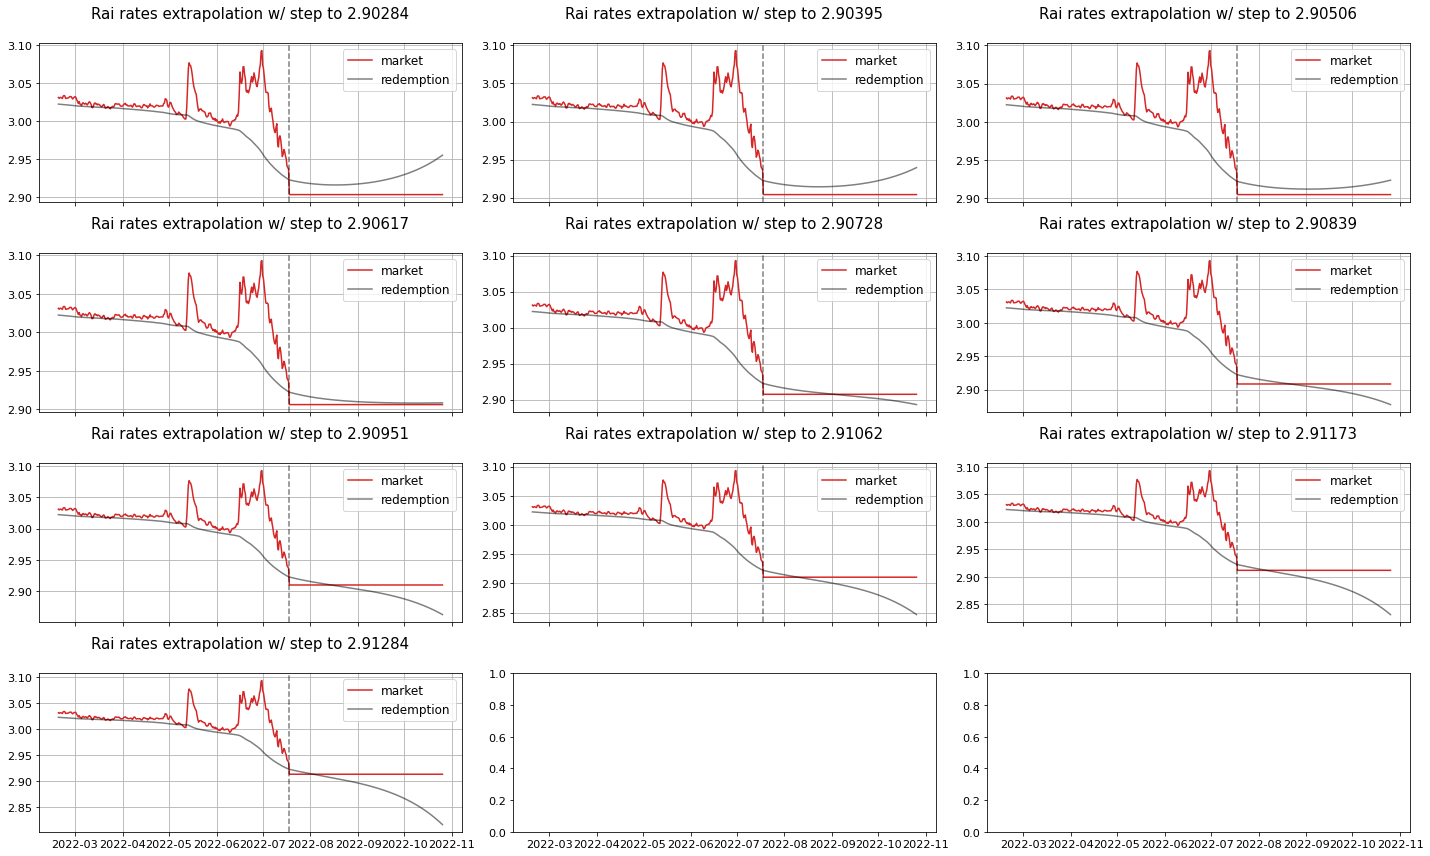

In [47]:
plot_steps(merged_steps, price_steps, f'output/controller_extrapolation_{len(price_steps)}_steps.png',
           last_timestamp, tight=True)